# Предсказание возраста покупателей по фотографии

Необходимо построить модель, определяющую по фотографии покупателя его возраст.\
С помощью данной модели супермаркет сможет фиксировать в прикассовой зоне возраст клиента с целью:
- анализа покупок клиента;
- выстраивания рекомендаций на основании истории покупок покупателя и его возрастной группы;
- контроль честности по отношению к продавцам при продаже алкоголя.

Цель: $MAE < 8$

### Библиотеки и модули

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

### Содержание
- Исследовательский анализ данных
- Обучение модели
- Анализ обученной модели

## 1. Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
print(f'Размер выборки: {labels.shape}')

Размер выборки: (7591, 2)


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1/255.
)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=7
                                                  )

Found 7591 validated image filenames.


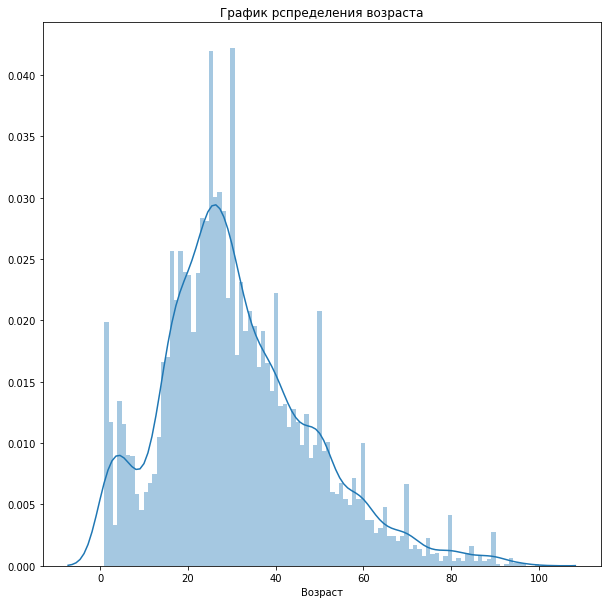

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.distplot(labels['real_age'], ax=ax, bins=100)
ax.set_title('График рспределения возраста')
ax.set_xlabel('Возраст')
plt.show()

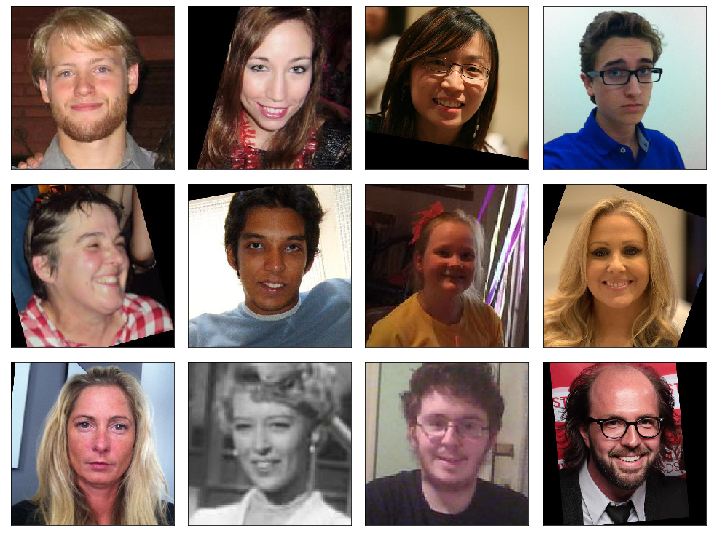

In [6]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Итак, распределение больше похоже на нормальное. Присутсвует два пика: один в районе 0-5 лет, другой - 20-30 лет. Наиболее часто встречается диапазон возраста 15-35 лет.
    
Проаналазировав выведенные фотографии, можно заметить, что некоторые фотографии уже в черно-белом цвете, а есть некоторые фотографии, у которых есть части полностью черного цвета, изображены разные эмоции на лицах. Однако, фотографии похожи тем, что представлены только лица людей.
    
В качестве аугментации подойдут следующие:
- отражение;
- изменение яркости и контрастности;
- размытие и повышение четкости;
- добавление шума.

## Обучение модели

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        horizontal_flip=True,
        validation_split=0.25
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=7
    )
    return train_gen_flow

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=7
    )
    return test_gen_flow

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
        
    )
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
    
    return model

In [ ]:
path = '/datasets/faces/'
data_train = load_train(path)
data_test = load_test(path)

In [ ]:
input_shape = (224, 224, 3)
model = create_model(input_shape)
trained_model = train_model(model, data_train, data_test)

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 111s - loss: 264.8120 - mae: 11.8525 - val_loss: 760.2807 - val_mae: 22.6513
Epoch 2/5
178/178 - 38s - loss: 101.6479 - mae: 7.5854 - val_loss: 518.9961 - val_mae: 17.7071
Epoch 3/5
178/178 - 38s - loss: 77.3112 - mae: 6.6564 - val_loss: 304.1540 - val_mae: 13.0050
Epoch 4/5
178/178 - 38s - loss: 64.0770 - mae: 6.0619 - val_loss: 137.9726 - val_mae: 9.0270
Epoch 5/5
178/178 - 38s - loss: 51.9587 - mae: 5.4832 - val_loss: 111.1497 - val_mae: 7.9972
60/60 - 9s - loss: 111.1497 - mae: 7.9972
Test MAE: 7.9972
```

## Анализ обученной модели

На тестовой выборке имеем следующее значение метрики качества MAE: 7.9972 < 8. Это значит, что возможное отклонение от настоящего возраста человека может составлять 8 лет.